In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

### Step 1: distortion correction
#### In the first step, we compute the camera calibration matrix and distortion coefficients given a set of chessboard images. We next apply the distortion correction to the raw image.

In [2]:
def camera_caliberation(file_names, nx=9, ny=6, display=True):
    """
    Compute the camera calibration matrix and distortion coefficients given a set of chessboard images    
    """
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(file_names)
    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        img_o=np.empty_like(img) # deep copy?
        img_o[:]=img
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            if display == True:# Draw and display the corners
                img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
                f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
                ax1.imshow(cv2.cvtColor(img_o, cv2.COLOR_BGR2RGB))
                ax1.set_title('Original Image', fontsize=14)
                ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                ax2.set_title('With Corners', fontsize=14)
    return objpoints, imgpoints
file_names='camera_cal/calibration*.jpg'
objpoints,imgpoints=camera_caliberation(file_names, display=False)

In [3]:
# Remove distortion from images
def rmv_distortion(img, objpts=objpoints, imgpts=imgpoints, display=True):
    
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpts, imgpts, img_size, None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    if display:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=14)
        ax2.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        ax2.set_title('Without Distortion', fontsize=14)
   
    return undist

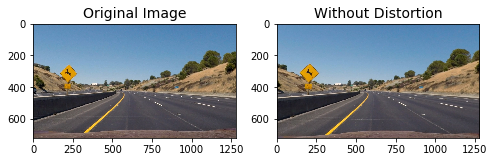

In [4]:
images = glob.glob('test_images/test2.jpg')
for image in images:
    img=cv2.imread(image)
    a=rmv_distortion(img)

### Step 2:  perspective transform
#### Use perspective transfrom to  create a bird’s eye view of the road.

In [5]:
def transform_view(img, display=True):
    """
    Use perspective transfrom to  create a bird’s eye view of the road.
    """
    
    img_size = (img.shape[1], img.shape[0])
    offset = 0
    src = np.float32([[490, 482],[810, 482],
                          [1250, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                         [1250, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size)
    if display == True:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
        f.tight_layout()
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title('Distortion Corrected', fontsize=14)
        ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
        ax2.set_title('Bird Eye View', fontsize=14)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    return warped, M    

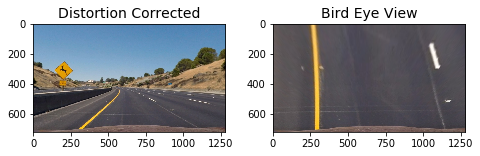

In [6]:
images = glob.glob('test_images/test2.jpg')
for image in images:
    img=cv2.imread(image)
    undist=rmv_distortion(img,display=False)
    b,c=transform_view(undist)

### Step 3: binary thresholding
#### Use color transforms, gradients, etc., to create a thresholded binary image. The following are the approaches suggested by the class.

In [7]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    thresh_min, thresh_max=thresh[0], thresh[1]
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Use inclusive (>=, <=) thresholds
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output

In [8]:
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

In [9]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output


#### I find that gradient-based approaches by themselves are not robust in situations of shadows or uneven pavement color. 

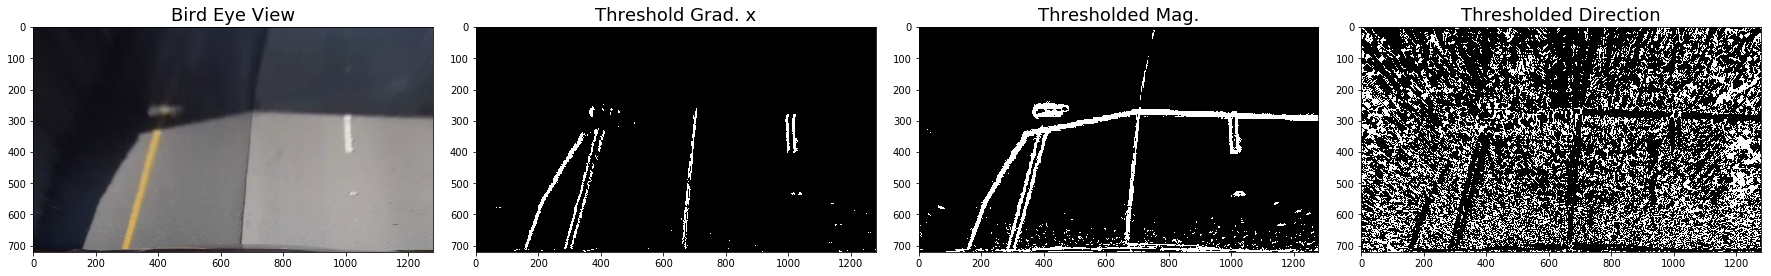

In [10]:
images = glob.glob('bridge/frame05.jpg')
for image in images:
    img=cv2.imread(image)
    undist=rmv_distortion(img,display=False)
    birdeye,M_tmp=transform_view(undist,display=False)
    grad_binary_x = abs_sobel_thresh(birdeye, orient='x', sobel_kernel=3, thresh=(20,100))
    mag_binary = mag_thresh(birdeye, sobel_kernel=3, mag_thresh=(10, 150))
    dir_binary = dir_threshold(birdeye, sobel_kernel=15, thresh=(0.7, 1.3))
    combined = np.zeros_like(dir_binary)
    combined[(grad_binary_x== 1) | (mag_binary == 1)] = 1
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 4))
    f.tight_layout()
    ax1.imshow(cv2.cvtColor(birdeye, cv2.COLOR_BGR2RGB))
    ax1.set_title('Bird Eye View', fontsize=18)
    ax2.imshow(grad_binary_x, cmap='gray')
    ax2.set_title('Threshold Grad. x', fontsize=18)
    ax3.imshow(mag_binary, cmap='gray')
    ax3.set_title('Thresholded Mag.', fontsize=18)
    ax4.imshow(dir_binary,cmap='gray')
    ax4.set_title('Thresholded Direction', fontsize=18)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [11]:
# Define a function that thresholds the H, L, or S channel of HLS
def hls_select(img, channel='s',thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    if channel=='h': # if H (hue) channel is selected
        tmp_channel = hls[:,:,0]
    elif channel == 'l': # if L (lightness) channel is selected
        tmp_channel = hls[:,:,1]
    elif channel == 's': # if S (saturation) channel is selected
        tmp_channel = hls[:,:,2]
    
    binary_output = np.zeros_like(tmp_channel)
    binary_output[(tmp_channel > thresh[0]) & (tmp_channel <= thresh[1])] = 1
    return binary_output

In [12]:
# Define a function that thresholds the H, L, or S channel of HLS
def rgb_select(img, channel='r',thresh=(0, 255)):
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if channel=='r': # if red channel is selected
        tmp_channel = rgb[:,:,0]
    elif channel == 'g': # if green  channel is selected
        tmp_channel = rgb[:,:,1]
    elif channel == 'b': # if blue channel is selected
        tmp_channel = rgb[:,:,2]
    
    binary_output = np.zeros_like(tmp_channel)
    binary_output[(tmp_channel > thresh[0]) & (tmp_channel <= thresh[1])] = 1
    return binary_output

#### After much trial and error, I came up with the following approach to provides a threshold masking that is robust in detecting yellow and white lane (for the project and challenge video). 

In [22]:
def select_yellow_white(img, 
                        yellow_hsv_low  = np.array([ 0, 100, 100], dtype ="uint8"),
                        yellow_hsv_high = np.array([ 120, 255, 255],dtype ="uint8"),
                        white_thresh=(185, 255), 
                        display=True):
    """
    Use HSV and RGB color space to mask the yellow and whie lane.
    """
    
    img_copy=np.copy(img)
    
    # Use HSV color space to mask the yellow lane.
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask_yellow=cv2.inRange(hsv, yellow_hsv_low, yellow_hsv_high)
    tmp_yellow = cv2.bitwise_and(img, img, mask=mask_yellow)
    tmp_yellow_gray=cv2.cvtColor(tmp_yellow,cv2.COLOR_BGR2GRAY)
    tmp_yellow_gray[:,img.shape[1]//2:img.shape[1]]=0
    
    # Use RGB color space to mask the white lane.
    tmp_white_gray=rgb_select(img_copy, channel='b', thresh =white_thresh)
    tmp_white_gray[:,0:img.shape[1]//2]=0
    binary_output=np.zeros_like(tmp_yellow_gray)
    
    # Combine the yellow and white masks.
    binary_output[(tmp_yellow_gray > 0) | (tmp_white_gray >0)] = 1
    
    if display==True:
        f, (ax1, ax2, ax3,ax4) = plt.subplots(1, 4, figsize=(16,4))
        ax1.imshow(cv2.cvtColor(img_copy,cv2.COLOR_BGR2RGB))
        ax1.set_title('Bird View', fontsize=14)
        ax2.imshow(cv2.cvtColor(tmp_yellow, cv2.COLOR_BGR2RGB))
        ax2.set_title('Yellow Mask', fontsize=14)    
        ax3.imshow(tmp_white_gray,cmap='gray')
        ax3.set_title('White Mask', fontsize=14) 
        ax4.imshow(binary_output,cmap='gray')
        ax4.set_title('Combined', fontsize=14) 
    return binary_output



#### The process is illustrated in the following. As shown in the images, this approach is robust in picking out the lane lines, even in the presence of shadows and uneven pavement color.

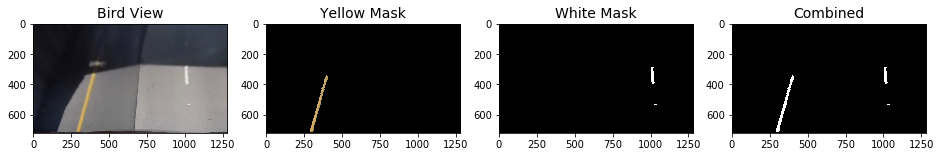

In [23]:
images = glob.glob('bridge/frame05.jpg')
for image in images:
    #print image
    img=cv2.imread(image)
    undist=rmv_distortion(img,display=False)
    birdeye,M_tmp=transform_view(undist,display=False)
    hsv_low = np.array([0, 100, 100], dtype="uint8")
    hsv_high = np.array([100, 255, 255],dtype ="uint8")
    select_yellow_white(birdeye, 
                        yellow_hsv_low = hsv_low,
                        yellow_hsv_high=hsv_high, 
                        white_thresh =(200,255))
   # ax1.set_title(image)

### Step 4: detect, fit, and plot the lane lines.
#### After applying calibration, thresholding, and a perspective transform to a road image, we have a binary image for the lane lines lane lines. In this section,  we first detect explicitly which pixels belong to left or right line. We then fit both lines with the 2nd order polynomial, check if the fitted results are reasonable, and plot the fitted curves. These steps are implemented in the function detect_fit_plot(binary).

#### We first define a class Line( ) to keep track of all the usefull parameters and results from frame to frame.

In [24]:
# Define a Line() class to keep track of all the useful parameters from frame to frame

QUEUE_LEN=10
from collections import deque

class Line:
    def __init__(self):
        # Was the line detected in the previous frame?
        self.detected = False
        
        # Remember x and y values 
        self.X = deque(maxlen = QUEUE_LEN)
        self.Y = deque(maxlen = QUEUE_LEN)
        
        # Store recent polynomial coefficients for averaging across frames
        self.fit = deque(maxlen=QUEUE_LEN)
        self.fit_last = None
        
        # Store recent x intercepts 
        self.x_intcep = deque(maxlen = QUEUE_LEN)
        self.x_intcep_last = None
        
        # Remember radius of curvature
        self.radius = deque(maxlen = QUEUE_LEN)
        self.radius_last = None
       
        # Count the number of frames processed
        self.count = 0
    # A method to update the attribute    
    def update(self, is_a_lane, X, Y, fit, roc, x_intcep, mode='full'):   
        # When there is a "good" fit, update everything
        if mode == 'full':
            self.detected = is_a_lane
            self.X.append(X)
            self.Y.append(Y) 
            self.fit.append(fit) 
            self.fit_last = fit
            self.x_intcep.append(x_intcep) 
            self.x_intcep_last =x_intcep
            self.radius.append(roc)
            self.radius_last = roc
            self.count += 1
        # Otherwise, just partial update.    
        elif mode =='partial':
            self.detected = is_a_lane
            self.count += 1
        

#### The following two fucntions both indentify the pixels belong to left and right lanes. The first one is a histogram based approach.  We scann the binary image from top to the bottom using a rectangle stripe. The length of the rectangle is the image length and the height is a design parameters.  For each scan, we calculate the histogram along all the columns in the scanned area. We use the two most prominent peaks in this histogram as bases for left and right lanes.  We then search all the pixels that fall into boxes that centers on the base positions.

In [39]:
def full_scan(binary,stripe_height=60, margin=50):
    """
    A function that takes thresholded binary image as an input and 
    output the coordinates of all the pixels that belongs to left/right lanes.
    
    binary: thresholed binary image
    stripe_height: the height of scanning stripe
    margin: 2*margin is the length of the scanning box
    """
    # Num. of stripes used for scan
    num_stripe=binary.shape[0]//stripe_height
    # lists to store indices of the pixels that belong to left/right lanes
    left_lane_inds, right_lane_inds = [],[]
    nonzero = binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Mid-point in x-direction for reference
    midpoint=binary.shape[1]//2
    print('midpoint', midpoint)
    # Loop through each stripe
    for i in range(num_stripe):
        binary_stripe=binary[i*stripe_height:(i+1)*stripe_height-1,:]
        # Calculate the histogram
        histogram = np.sum(binary_stripe,axis=0)  
        # Left and right base in x-direction to setup the box
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        have_left_box, have_right_box =False, False
        box_y_low, box_y_high=i*stripe_height, (i+1)*stripe_height-1
        # If histogram has a left max
        if leftx_base!=0:
            have_left_box=True  
            box_x_left_low, box_x_left_high = max(0,leftx_base-margin), min(leftx_base+margin, binary.shape[1]//2)
        # If histogram has a right max
        if rightx_base>binary.shape[1]//2:
            have_right_box = True
            box_x_right_low, box_x_right_high = max(binary.shape[1]//2,rightx_base-margin),min(rightx_base+margin, binary.shape[1])
        # If we have a legitimate left box, append all the indices of pixels that are within the boundary of the box
        if have_left_box:
            #cv2.rectangle(out_img,(box_x_left_low,box_y_low),(box_x_left_high,box_y_high),(0,255,0), 4) 
            good_left_inds = ((nonzeroy >= box_y_low) & (nonzeroy < box_y_high) & 
                           (nonzerox >= box_x_left_low) & (nonzerox < box_x_left_high)).nonzero()[0]   
            left_lane_inds.append(good_left_inds)
        # If we have a legitimate right box, append all the indices of pixels that are within the boundary of the box
        if have_right_box:
            #cv2.rectangle(out_img,(box_x_right_low,box_y_low),(box_x_right_high,box_y_high),(0,255,0), 4) 
            good_right_inds = ((nonzeroy >= box_y_low) & (nonzeroy < box_y_high) & 
                                (nonzerox >= box_x_right_low) & (nonzerox < box_x_right_high)).nonzero()[0]
            right_lane_inds.append(good_right_inds)
    
    #Consolidate all the indices
    if len(left_lane_inds)>0:
        left_lane_inds = np.concatenate(left_lane_inds)
        leftx, lefty = nonzerox[left_lane_inds],nonzeroy[left_lane_inds]
    else: # return empty list.
        leftx, lefty = [], []
    if len(right_lane_inds)>0:        
        right_lane_inds = np.concatenate(right_lane_inds)
        rightx, righty = nonzerox[right_lane_inds], nonzeroy[right_lane_inds] 
    else:
        rightx, righty=[],[]   


    return leftx, lefty, rightx, righty        
        



#### If we fit both lanes successfully in one frame of video, in the next frame we can simplify the task by searching in a margin around the previous fitted line positions .

In [40]:
def simple_scan(binary, p_left_fit, p_right_fit, margin=100):
    """
    If the previous fit is successful, we search in a margin around the previous fitted line position.
    INPUT
      binary: thresholed binary image
      p_leftfit, p_rightfit: coefficients of the curves fitted in the last frame
      margin: search range left and right to a reference point
    
    OUTPUT
      Coordinates of the pixels belong to left and right lanes.
    """
    
    # lists to store indices of the pixels that belong to left/right lanes
    left_lane_inds, right_lane_inds = [],[]
    nonzero = binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Use the previously fitted lanes as references for search
    left_lane_inds = ((nonzerox > (p_left_fit[0]*(nonzeroy**2)
                                       + p_left_fit[1]*nonzeroy + p_left_fit[2] - margin))
                          & (nonzerox < (p_left_fit[0]*(nonzeroy**2) 
                                         + p_left_fit[1]*nonzeroy + p_left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (p_right_fit[0]*(nonzeroy**2) 
                                        + p_right_fit[1]*nonzeroy + p_right_fit[2] - margin)) 
                          & (nonzerox < (p_right_fit[0]*(nonzeroy**2) 
                                        + p_right_fit[1]*nonzeroy + p_right_fit[2] + margin)))  
    
    #Consolidate all the indices
    if len(left_lane_inds)>0:
        #left_lane_inds = np.concatenate(left_lane_inds)
        leftx, lefty = nonzerox[left_lane_inds],nonzeroy[left_lane_inds]
    else: # return empty list.
        leftx, lefty = [], []
    if len(right_lane_inds)>0:        
        #right_lane_inds = np.concatenate(right_lane_inds)
        rightx, righty = nonzerox[right_lane_inds], nonzeroy[right_lane_inds] 
    else:
        rightx, righty=[],[]   


    return leftx, lefty, rightx, righty   


#### Fit a second order polynomial and calcuate radius of curvature and intercepts at the top and bottom of the frame.

In [41]:
def fit_lane(x,y, img_height =720):
    """
    Fit x, y with a second order polynomial and ouput the coefficients for the polynomial, 
    coordinates of the fitted curve, radius of curvature, intercepts at the top and bottom of the frame
    """
    # Measure Radius of Curvature for each lane line
    y_m_pix = 30./720 # meters per pixel in y dimension
    x_m_pix = 3.7/700 # meteres per pixel in x dimension
    
    # Fit with coordinates 
    fit = np.polyfit(y, x, 2)
    # Generate x and y values for plotting
    fit_y = np.linspace(0, img_height-1, img_height)
    fit_x = fit[0]*fit_y**2 + fit[1]*fit_y + fit[2]
      
    # Fit with "meters"    
    fit_cr = np.polyfit(y*y_m_pix, x*x_m_pix, 2)
    
    # Calculate radius of curvature
    roc = ((1 + (2*fit_cr[0]*np.max(y)*y_m_pix + fit_cr[1])**2)**1.5)/np.absolute(2*fit_cr[0])
    
    # Calculate the intercepts at the top and bottom of the frame
    x_intcep=[fit_x[0],fit_x[img_height-1]]
    
    return fit, fit_y, fit_x, roc, x_intcep

    

#### Use simple "rule of thumb" to check if the results of the curve fitting are reasonable. In other words, we need to make sure that a detected lane is a "real thing".

In [42]:
def check_fit_result_left(roc, x_intcep, status, mode='1'):
    """
    Use following "rule of thumb" to make sanity check on the left lanes.
    1. Radius curvature should not be too large or too small.
    2. The coordinates of the top and bottom intercepts shall fall into the range of [0, 640]
    3. The bottom x-intercept shall not deviate too match from that of the previous frame.
    """
    is_a_lane = False
    if mode=='1':
        if ((roc>=100) & (roc<=5e5) & (np.all(x_intcep>=[0,0])) & (np.all(x_intcep<=[640,640]))):
            is_a_lane = True
    elif mode =='2':
        if  ((roc>=100) & (roc<=5e5) & (np.all(x_intcep>=[0,0])) & (np.all(x_intcep<=[640,640]))
             &(abs(x_intcep[1]-status.x_intcep_last[1])<=50)):     
            is_a_lane = True
    return is_a_lane  

def check_fit_result_right(roc, x_intcep, status, mode='1'):
    """
    Use following "rule of thumb" to make sanity check on the right lanes.
    1. Radius curvature should not be too large or too small.
    2. The coordinates of the top and bottom intercepts shall fall into the range of [640, 1280]
    3. The bottom x-intercept shall not deviate too match from that of the previous frame.
    """
    is_a_lane = False
    if mode=='1':
        if ((roc>=100) & (roc<=5e5) & (np.all(x_intcep>=[640,640])) & (np.all(x_intcep<=[1280,1280]))):
            is_a_lane = True
    elif mode =='2':
        if  ((roc>=100) & (roc<=5e5) & (np.all(x_intcep>=[640,640])) & (np.all(x_intcep<=[1280,1280]))
             &(abs(x_intcep[1]-status.x_intcep_last[1])<=50)):     
            is_a_lane = True
    return is_a_lane  

In [85]:
def plot_lanes(fit_leftx, fit_rightx, fity, img_shape=(720,1280)):
    """
    Plot the fitted curves and mark the area between the curves. 
    Transform back to the perspective of a mounted camera.
    """
    blank=np.zeros([img_shape[0],img_shape[1]],dtype=np.uint8)
    tmp_img = np.dstack((blank, blank, blank))*255
    
    
    fit_leftx = [round(x) for x in fit_leftx]
    fit_rightx = [round(x) for x in fit_rightx]
    fity = [round(x) for x in fity]
    
    #print(fit_leftx[0:10])
    a=list(zip(fit_leftx, fity))
    b=list(zip(fit_rightx, fity))
    #print(a[0:10])
   # print(fit_leftx.type)
   # print(fity.type)
    # construct the data structure to plot the fitted lanes
    #poly_pts_left=np.array(zip(fit_leftx,fity)).astype(int)
    poly_pts_left=np.array(a).astype(int)
    #poly_pts_right=np.array(zip(fit_rightx,fity)).astype(int)
    poly_pts_right=np.array(b).astype(int)
    poly_pts=np.vstack((poly_pts_left,poly_pts_right)).reshape((-1,1,2))
   # print(poly_pts_left)
    # Construct the data structure to fill the area between the lane lines
    space=30
    no_poly=img_shape[0]//space
    poly_pts_fill=np.zeros((no_poly,4,2))
    for i in range(no_poly):
        poly_pts_fill[i,:,:]=[poly_pts_left[(i+1)*space-1],poly_pts_left[i*space], 
                               poly_pts_right[i*space], poly_pts_right[(i+1)*space-1]]
    poly_pts_fill1=np.array(poly_pts_fill,np.int32)
    
    # Mark the deteced curves and areas between the two lanes:
    cv2.polylines(tmp_img, poly_pts, isClosed=True, color=[255, 0, 0], thickness = 60)
    cv2.fillPoly(tmp_img, poly_pts_fill1, (125,238, 215))
    
    # Tranform back to the prespective of a mounted camera
    src = np.float32([[490, 482],[810, 482],
                   [1250, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                 [1250, 720],[40, 720]])
    Minv = cv2.getPerspectiveTransform(dst, src)
    plotted_lane_birdeye = tmp_img.copy()
    plotted_lane_camera = cv2.warpPerspective(tmp_img, Minv, (img_shape[1], img_shape[0]))
    return plotted_lane_camera, plotted_lane_birdeye

#### This is the main function the detect, fit check, and plot the lane lines.

In [71]:
def detect_fit_plot(binary):
    """
    This function implements the following:
    1) Take a binary image as the input and detect explicitly which pixels belong to left or right line. 
    2) fit both lines with the 2nd order polynomial, check if the fitted results are reasonable, 
    3) If there a bad or difficult frame, we use the previous positions from the frame prior.
    4) Plot the fitted curves to mark the lanes.
    """
    
    # When dealing with the first few frames and when the provious detection failed, use full scan.
    if (left_status.count<3)|(left_status.detected==False)|(right_status.detected ==False):
        leftx,lefty,rightx,righty=full_scan(binary)
    else:   # otherwise, use simple sacnn. 
        leftx,lefty,rightx,righty=simple_scan(binary, left_status.fit_last, right_status.fit_last)
   
    fit_complete_left, fit_complete_right = False, False
    if len(lefty)>=50: # if there are enough data to fit the curve
        #enough_data_left = True
        left_fit, fity, fit_leftx, l_roc, l_x_intcep = fit_lane(leftx, lefty)
        # Sanity check
        if left_status.x_intcep_last is None:
            is_lane_left = check_fit_result_left(l_roc, l_x_intcep, left_status)  
        else:
            is_lane_left = check_fit_result_left(l_roc, l_x_intcep, left_status, mode='2')  
        
        if is_lane_left: # If the results of the curve fitting are reasonable
            left_status.update(True, leftx, lefty, left_fit, l_roc, l_x_intcep)
            fit_complete_left = True
        else:    # otherwise, use the results from the previous frame.
            left_status.update(False, [], [], [], [], [], mode='partial')
            if (len(left_status.fit)>0):
                fity = np.linspace(0, binary.shape[0]-1, binary.shape[0])
                left_fit = left_status.fit_last
                fit_leftx = left_fit[0]*fity**2 + left_fit[1]*fity + left_fit[2]
                l_roc = left_status.radius_last
                l_x_intcep =left_status.x_intcep_last
                fit_complete_left = True
    else:   # if there are not enough data to fit the curve, use the previous fitted result if possible.
        left_status.update(False, [], [], [], [], [], mode='partial')
        if (len(left_status.fit)>0):
                fity = np.linspace(0, binary.shape[0]-1, binary.shape[0])
                left_fit = left_status.fit_last
                fit_leftx = left_fit[0]*fity**2 + left_fit[1]*fity + left_fit[2]
                l_roc = left_status.radius_last
                l_x_intcep =left_status.x_intcep_last
                fit_complete_left = True
         
    if len(righty)>=50:
        #enough_data_right = True
        right_fit, fity, fit_rightx, r_roc, r_x_intcep = fit_lane(rightx, righty)
        if right_status.x_intcep_last is None:  
            is_lane_right = check_fit_result_right(r_roc, r_x_intcep, right_status)   
        else:
            is_lane_right = check_fit_result_right(r_roc, r_x_intcep, right_status, mode='2')   
        if is_lane_right:
            right_status.update(True, rightx, righty, right_fit, r_roc, r_x_intcep)
            fit_complete_right = True
        else:    
            right_status.update(False, [], [], [], [], [], mode='partial')
            if (len(right_status.fit)>0):
                fity = np.linspace(0, binary.shape[0]-1, binary.shape[0])
                right_fit = right_status.fit_last
                fit_rightx = right_fit[0]*fity**2 + right_fit[1]*fity + right_fit[2]
                r_roc = right_status.radius_last
                r_x_intcep =right_status.x_intcep_last
                fit_complete_right = True
    else:
        right_status.update(False, [], [], [], [], [], mode='partial')
        if (len(right_status.fit)>0):
                fity = np.linspace(0, binary.shape[0]-1, binary.shape[0])
                right_fit = right_status.fit_last
                fit_rightx = right_fit[0]*fity**2 + right_fit[1]*fity + right_fit[2]
                r_roc = right_status.radius_last
                r_x_intcep =right_status.x_intcep_last
                fit_complete_right = True
    # If we have curves to plot
    if ((fit_complete_left) & (fit_complete_right)):
         plotted_lane_camera, plotted_lane_birdeye = plot_lanes(fit_leftx, fit_rightx, fity)    
         offset = ((l_x_intcep[1]+r_x_intcep[1])/2-binary.shape[1]/2)*(3.7/(r_x_intcep[1]-l_x_intcep[1]))   
    else: # otherwise output a tranparent image and diagnostic information
         blank=np.zeros([binary.shape[0],binary.shape[1]],dtype=np.uint8)
         blank_img = np.dstack((blank, blank, blank))*255
         plotted_lane_camera, plotted_lane_birdeye =blank_img, blank_img
         l_roc, r_roc, offset = 0, 0, 0 
            
    return plotted_lane_camera, l_roc, r_roc, offset


In [72]:
def display_info(overlay, l_roc, r_roc, offset):
    """
    Diplay information of radius curvature and offset (to the center of the lane)
    """
    L_ROC_FONT_COLOR =(0,0,255) 
    R_ROC_FONT_COLOR =(0,0,255) 
    OFFSET_FONT_COLOR = (255,255,255) if abs(offset*100)<=50 else (255,0,0)
   
    if offset <0:
        cv2.putText(overlay, '{:.2f}cm right off center'.format(abs(offset)*100), (360,80),
                 fontFace = 16, fontScale = 2, color=OFFSET_FONT_COLOR, thickness = 3)
    else:
        cv2.putText(overlay, '{:.2f}cm left off center'.format(abs(offset)*100), (300,80),
                 fontFace = 16, fontScale = 2, color=OFFSET_FONT_COLOR, thickness = 3)
    # Display radius of curvature on video
    if (l_roc<1e4):
        cv2.putText(overlay, 'L_ROC:{}m'.format(int(l_roc)), (100,550),
                 fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 2, color=L_ROC_FONT_COLOR, thickness = 3)
    if (r_roc<1e4):    
        cv2.putText(overlay, 'R_ROC:{}m'.format(int(r_roc)), (800,550),
                 fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 2, color=R_ROC_FONT_COLOR, thickness = 3)
    return overlay

In [73]:
def pipeline(img):
    """
    The pipeline function that implements end-to-end lane detection
    """
    # remove the distortion
    undist=rmv_distortion(img,display=False)
    # view transform
    birdeye,M_tmp=transform_view(undist,display=False)
    # Thresholding
    hsv_low = np.array([0, 100, 100], dtype="uint8")
    hsv_high = np.array([100, 255, 255],dtype ="uint8")
    binary=select_yellow_white(birdeye, 
                        yellow_hsv_low = hsv_low,
                        yellow_hsv_high=hsv_high, 
                        white_thresh =(200,255),display=False)
    # Detect, fit and plot the line
    lane, l_roc, r_roc, offset=detect_fit_plot(binary)   
    # Save problmatic images
    if (l_roc==0) & (r_roc==0) & (offset==0):
             file_name='diagnostic/frame'+str(left_status.count+1)+'.jpg'
             cv2.imwrite(file_name,img)
    # Overlay with the image
    overlay = cv2.addWeighted(img, 1, lane, 0.6, 0)  
    display_info(overlay, l_roc, r_roc, offset)
    return overlay



midpoint 640
midpoint 640
midpoint 640
midpoint 640


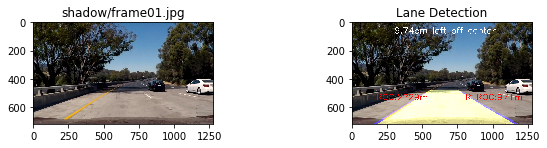

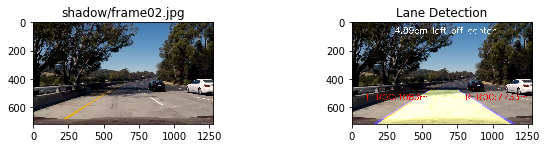

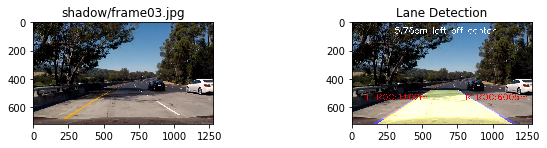

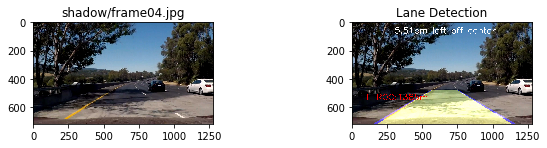

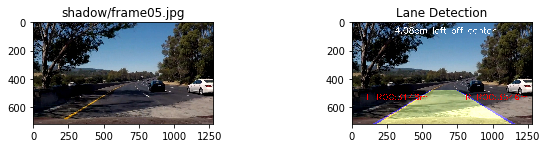

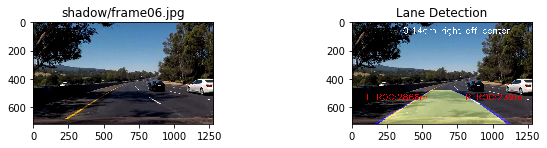

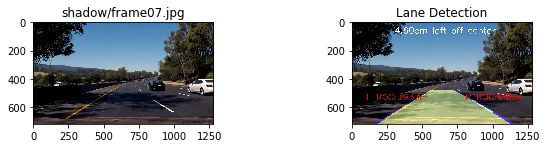

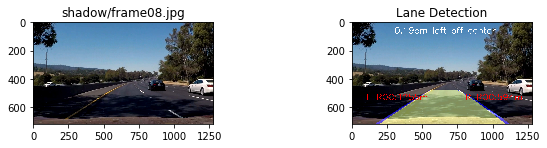

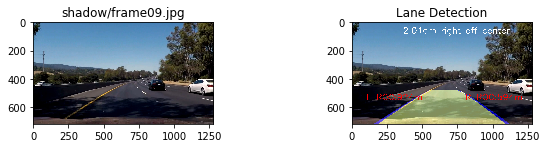

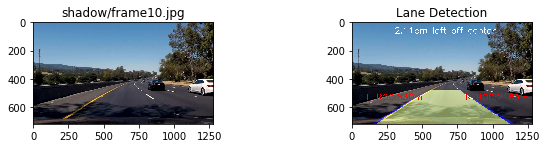

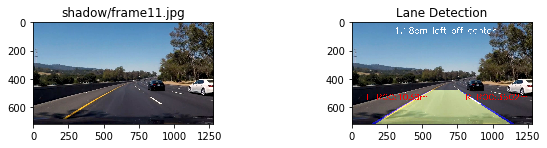

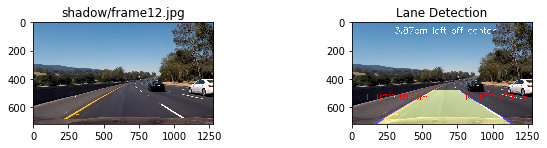

In [86]:
left_status=Line()
right_status=Line()
images = glob.glob('shadow/frame*.jpg')
for image in images: 
   
    img=cv2.imread(image)
    f, (ax1,ax2) = plt.subplots(1,2, figsize=(9,2))
    f.tight_layout()
    ax1.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    ax1.set_title(image)
    ax2.imshow(cv2.cvtColor(pipeline(img),cv2.COLOR_BGR2RGB))
    ax2.set_title('Lane Detection')


In [59]:
type(img)

numpy.ndarray

In [ ]:
# Project Video
left_status=Line()
right_status=Line()
file_names='camera_cal/calibration*.jpg'
objpoints,imgpoints=camera_caliberation(file_names, display=False)
from moviepy.editor import VideoFileClip
video_output = 'sub_project_video_v5.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) 
white_clip.write_videofile(video_output, audio=False)

In [ ]:
# Challenge Video
left_status=Line()
right_status=Line()
file_names='camera_cal/calibration*.jpg'
objpoints,imgpoints=camera_caliberation(file_names, display=False)
from moviepy.editor import VideoFileClip
video_output = 'sub_challenge_video_v5.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(pipeline) 
white_clip.write_videofile(video_output, audio=False)